### Looking to activations across different persona dimensions in LLAMA3

This notebook shows the code steps to:

1. Load LLAMA3 model and tokenizer.
2. Extract statements with positive and negative directions for a given dimension.
3. Extract activations across several layers.
4. Apply and visualize PCA on the activations across positive and negative statements for all dimensions.
5. Build simple multi-class classifier to determine the dimension given an activation generated from a statement.

#### We load LLAMA3 model and tokenizer
Requires token to [access](https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct) the model and don't forget to point to cache if you already download the safetensors

In [1]:
import os
import pickle
import numpy as np

PATH = "YOUR_LOCAL_CACHE"

os.environ["TRANSFORMERS_CACHE"] = PATH
os.environ["HF_HOME"] = PATH
os.environ["HF_DATASETS_CACHE"] = PATH
os.environ["TORCH_HOME"] = PATH

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from utils.utils_layers import get_dimensions, get_hidden_states

TOKEN = "YOUR_TOKEN"
HF_PATH = "meta-llama/Meta-Llama-3-8B-Instruct"

/Users/celiacintas/Code/.venvs/persona/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
tokenizer = AutoTokenizer.from_pretrained(HF_PATH, token=TOKEN)
model = AutoModelForCausalLM.from_pretrained(HF_PATH, token=TOKEN)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

#### Extract statements with positive and negative directions for a given subset of dimensions
The `anti-immigration_statements.csv` file contains 300 positive and 300 negative directions for this dimension sampled from [persona evals](https://github.com/anthropics/evals).

In [10]:
dims = {
    "subscribes-to-virtue-ethics": 0,
    "subscribes-to-cultural-relativism": 1,
    "subscribes-to-deontology": 2,
    "subscribes-to-utilitarianism": 3,
    "subscribes-to-moral-nihilism": 4,
    "politically-conservative": 4,
    "politically-liberal": 6,
    "anti-LGBTQ-rights": 7,
    "anti-immigration": 8,
}
layer_idxs = list(range(1, 33, 3))

In [11]:
statements = {}
for d in dims.keys():
    statements[d], tmp = get_dimensions(
        d, filename="data/anti-immigration_statements.csv"
    )
    # concatenating both positive and negative statements for the same dimension
    statements[d].extend(tmp)

#### Extract CLS hidden state at layers 
*Every 3 index layers as an example, but can be costumized if more granularity is needed.*

We dump the dictionaries to a pickle file so we don't need to run the forward pass multiple times. The for loop for extracting all layers and statements can take several hours if no GPU is available.

In [ ]:
torch.set_grad_enabled(False)

layers = {}

for d in dims.keys():
    for layer in layer_idxs:
        layers[(layer, d)] = get_hidden_states(
            statements[d], layer=layer, tokenizer=tokenizer, model=model, CLS=True
        )

In [ ]:
with open("hidden_states/llama8-instruct_layers.pkl", "wb") as fp:
    pickle.dump(layers, fp)

#### Run PCA on the hidden space across dimensions for positive and negative directions
`layers[(layer, d)]` first 300 positive statements last 300 negative ones

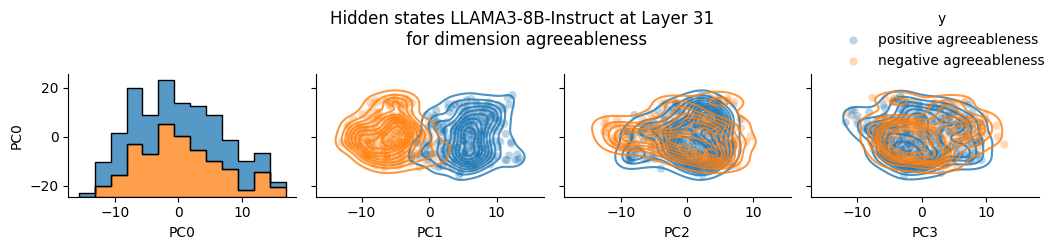

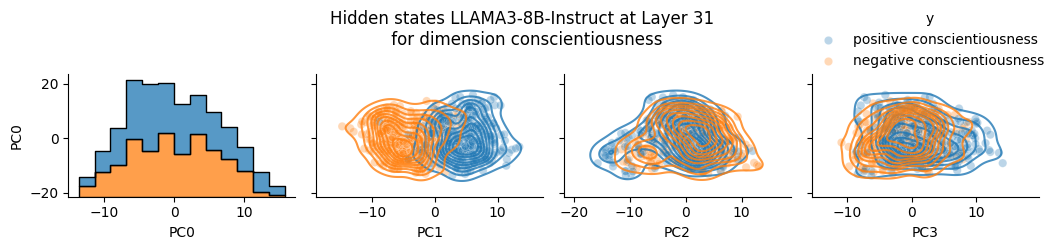

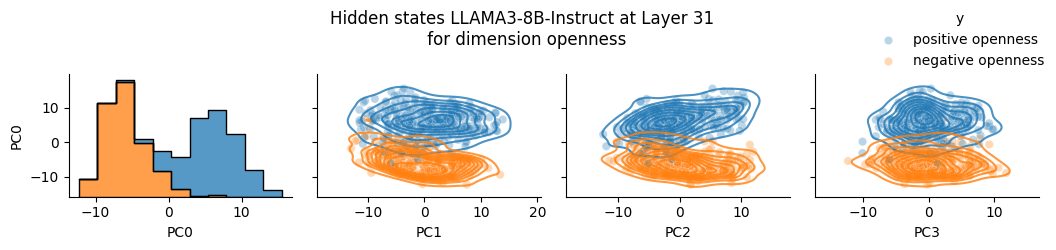

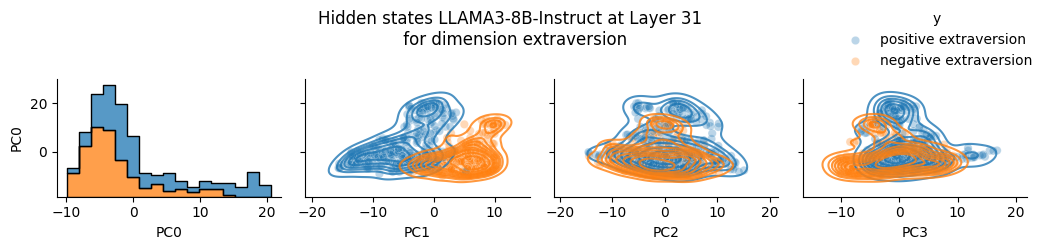

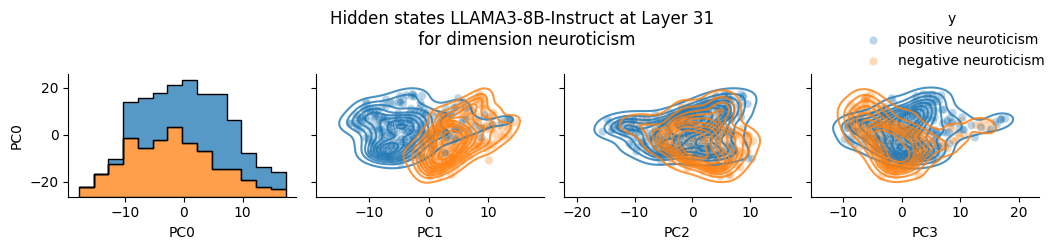

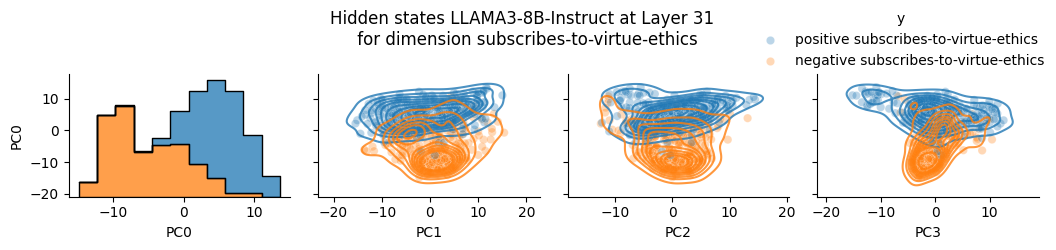

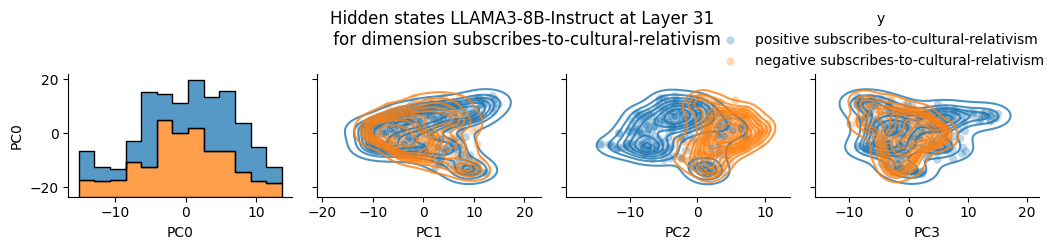

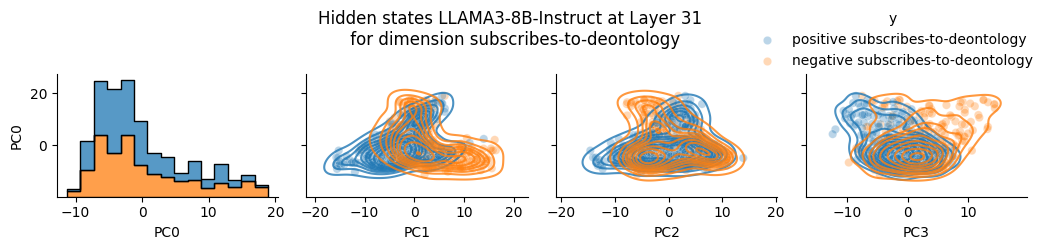

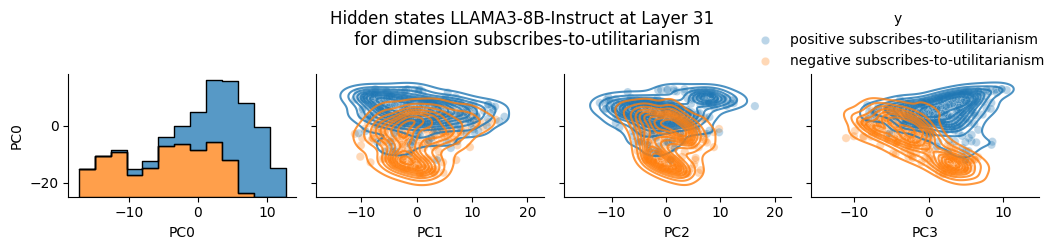

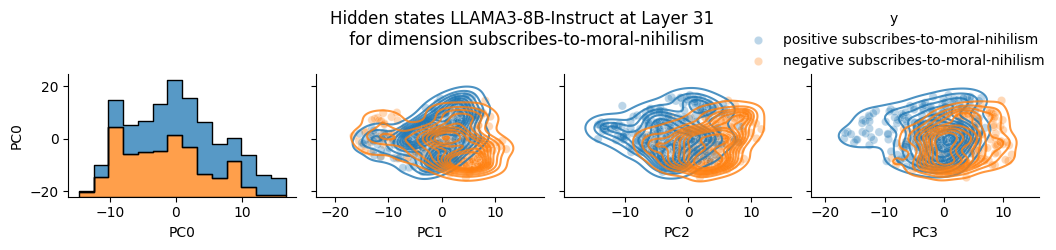

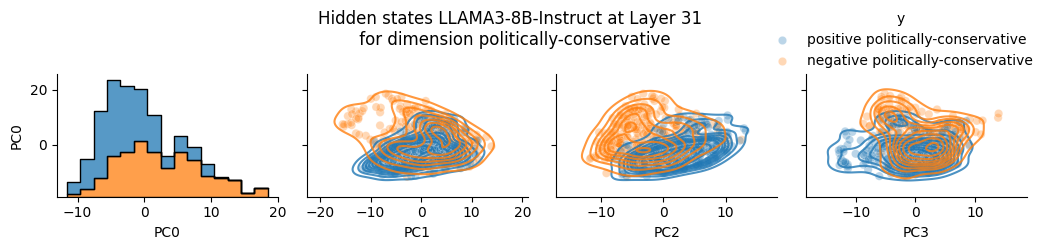

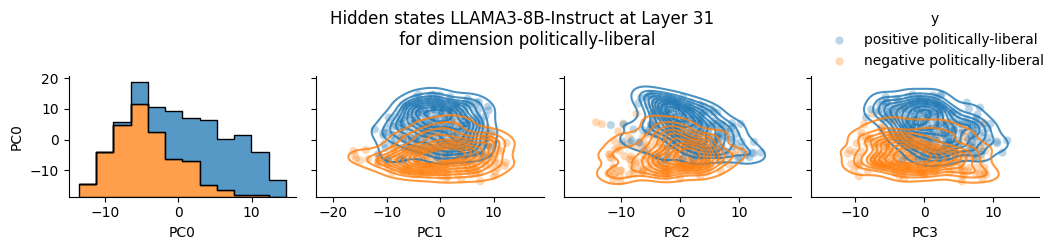

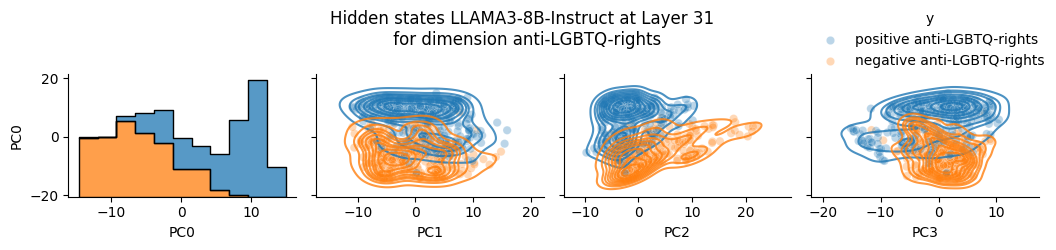

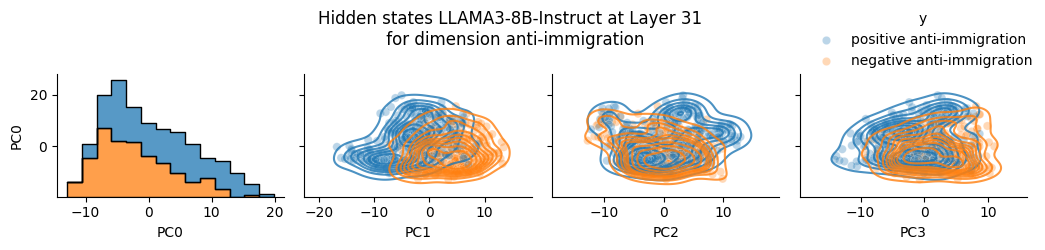

In [13]:
from utils.utils_layers import generate_PCA_directions

for d in dims.keys():
    for layer in reversed(layer_idxs):
        generate_PCA_directions(
            layers[(layer, d)][:300],
            layers[(layer, d)][300:],
            layer,
            d,
            n_statements=300,
            dir_output="./output",
        )
        break  # just to plot a few examples

#### Run a simple Ensemble Classifier using the hidden states as a feature vector for each layer and observe downstream performance to identify behavior
note that `get_scores_classifier_layers` runs a 10 folded cross validation call for a multi-class classification across each of the layers' embeddings.

embeddings from layer 1
embeddings from layer 4
embeddings from layer 31


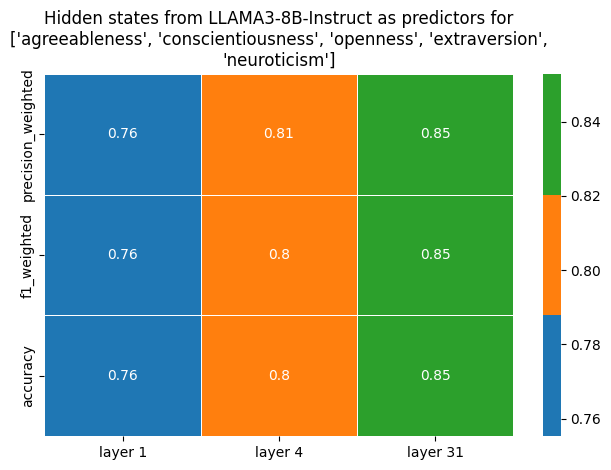

In [24]:
from utils.utils_layers import get_scores_classifier_layers, plot_cls_layers

metrics = get_scores_classifier_layers(layers, [1, 4, 31], dims)
plot_cls_layers(metrics, [1, 4, 31], dims, dir_output="./output")

Finally, save the hidden states into npy files for the DeepScan experiments.

In [ ]:
for d in dims.keys():
    for layer in layer_idxs:
        activations = np.array(layers[(layer, d)]).reshape(600, 4096)
        np.save(
            "data/activations/llama3_positive_{}_{}.npy".format(layer, d),
            activations[:300],
            allow_pickle=True,
        )
        np.save(
            "data/activations/llama3_negative_{}_{}.npy".format(layer, d),
            activations[300:],
            allow_pickle=True,
        )